In [2]:
# Movie Recommendation System Pipeline

# SECTION 1: Libraries & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity


In [4]:
# Load datasets
movies = pd.read_csv('./movies_recomm/movies.csv')
ratings = pd.read_csv('./movies_recomm/ratings.csv')

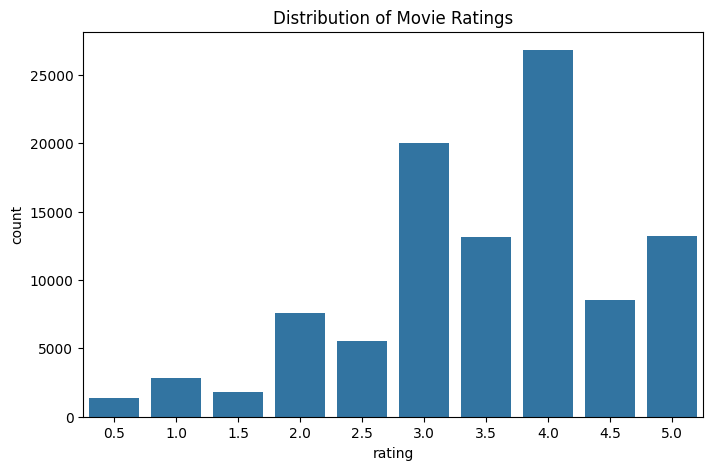

In [6]:
# SECTION 2: EDA
# Ratings distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Movie Ratings')
plt.show()

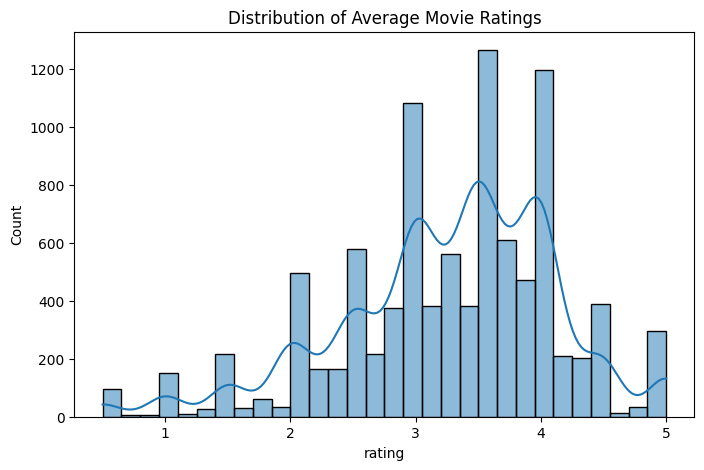

In [8]:
# Average rating per movie
average_ratings = ratings.groupby('movieId')['rating'].mean()
plt.figure(figsize=(8, 5))
sns.histplot(average_ratings, bins=30, kde=True)
plt.title('Distribution of Average Movie Ratings')
plt.show()

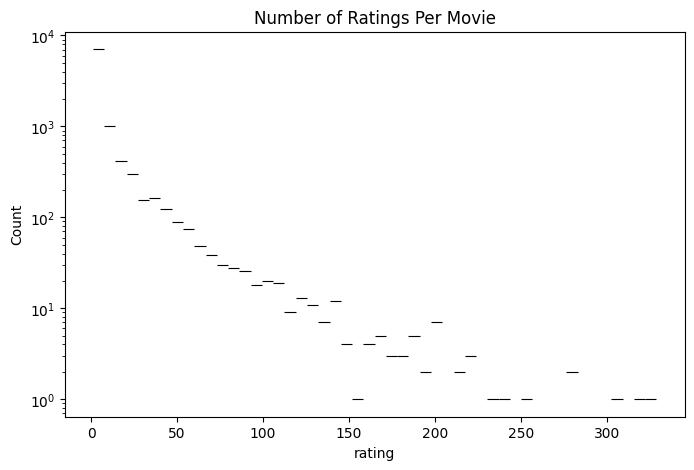

In [10]:
# Number of ratings per movie
ratings_count = ratings.groupby('movieId')['rating'].count()
plt.figure(figsize=(8, 5))
sns.histplot(ratings_count, bins=50, log_scale=(False, True))
plt.title('Number of Ratings Per Movie')
plt.show()

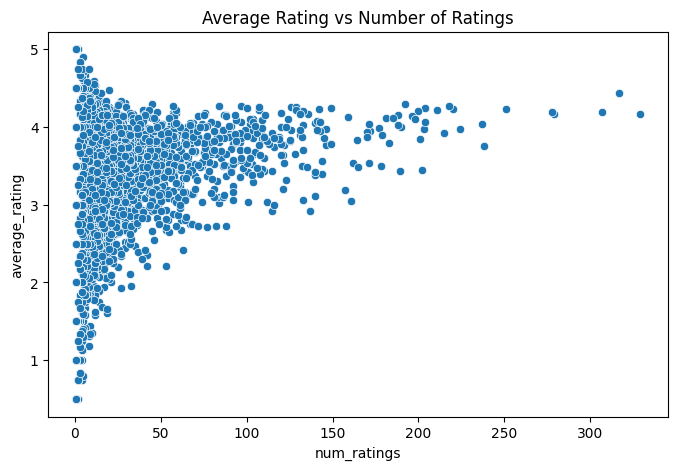

In [12]:
# Correlation between average rating & number of ratings
ratings_summary = pd.DataFrame({'average_rating': average_ratings, 'num_ratings': ratings_count})
plt.figure(figsize=(8, 5))
sns.scatterplot(x='num_ratings', y='average_rating', data=ratings_summary)
plt.title('Average Rating vs Number of Ratings')
plt.show()

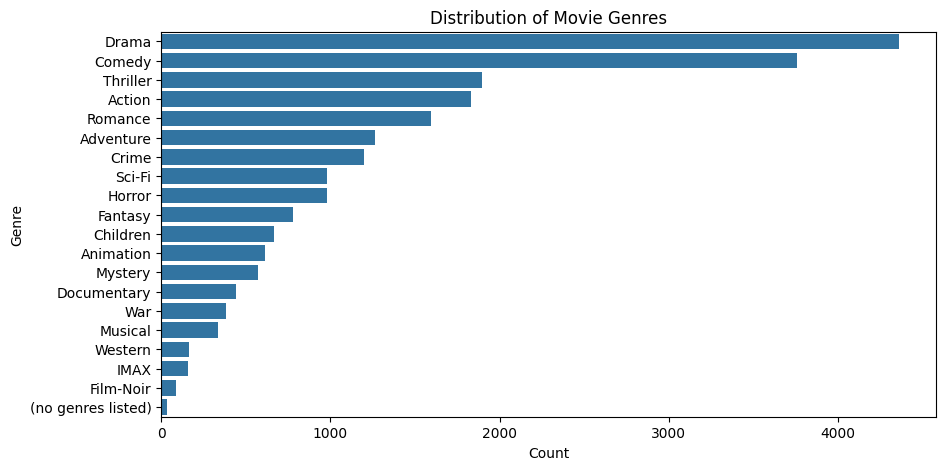

In [14]:
# Additional EDA: Genre distribution
movies['genres'] = movies['genres'].str.split('|')
all_genres = movies.explode('genres')['genres']
plt.figure(figsize=(10, 5))
sns.countplot(y=all_genres, order=all_genres.value_counts().index)
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


In [16]:
# SECTION 3: Preprocessing & Feature Engineering
# Weighted ratings (Popularity-based filtering)
movie_stats = ratings.groupby('movieId').agg(average_rating=('rating', 'mean'), num_ratings=('rating', 'count')).reset_index()
movie_stats = pd.merge(movie_stats, movies[['movieId', 'title']], on='movieId')
C = movie_stats['average_rating'].mean()
m = movie_stats['num_ratings'].quantile(0.75)
qualified_movies = movie_stats[movie_stats['num_ratings'] >= m].copy()
qualified_movies['weighted_rating'] = (
    (qualified_movies['num_ratings'] / (qualified_movies['num_ratings'] + m)) * qualified_movies['average_rating'] +
    (m / (qualified_movies['num_ratings'] + m)) * C
)

/var/folders/5j/21g__tmn49j37fc_6jm0546c0000gn/T/ipykernel_28246/2615869505.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weighted_rating', y='title', data=top_movies, palette='viridis')


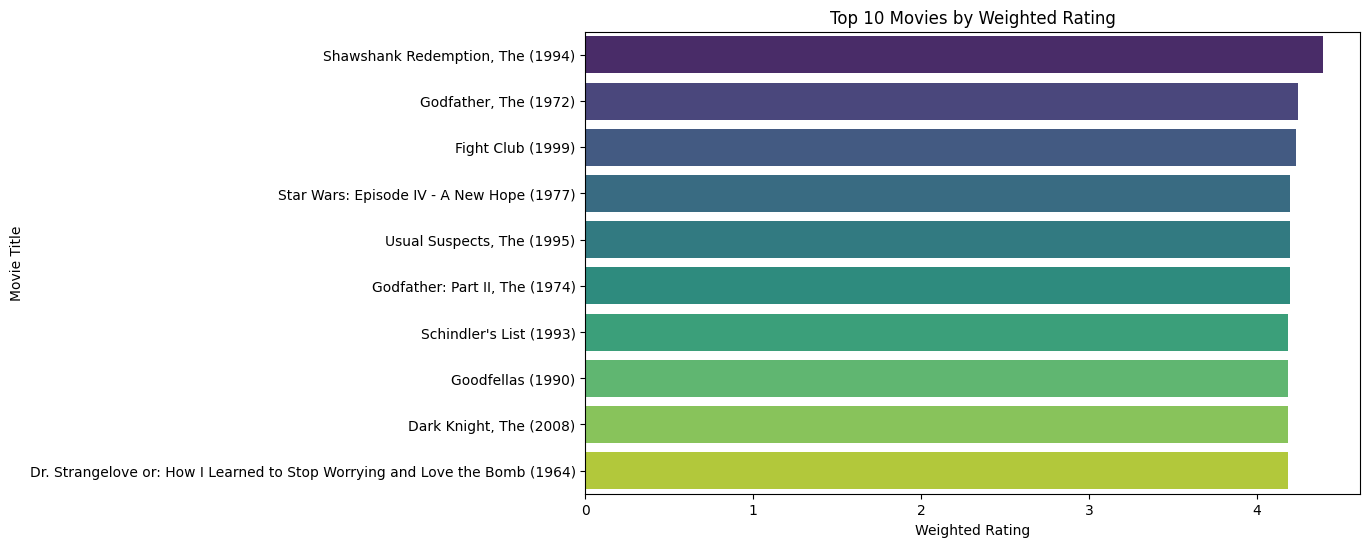

In [20]:
# Plot top movies by weighted rating
top_movies = qualified_movies.sort_values('weighted_rating', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='weighted_rating', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Movies by Weighted Rating')
plt.xlabel('Weighted Rating')
plt.ylabel('Movie Title')
plt.show()

In [22]:
# Genre encoding (Content-based filtering)
genres_encoded = movies['genres'].explode().str.get_dummies().groupby(movies['movieId']).sum().reset_index()
movies_with_genres = pd.merge(movies[['movieId', 'title']], genres_encoded, on='movieId')

In [24]:
# SECTION 4: Classification Model (High/Low Rated Movies)
classification_data = pd.merge(movie_stats, movies_with_genres.drop(columns=['title']), on='movieId')
classification_data['high_rating'] = (classification_data['average_rating'] >= 3.5).astype(int)
X = classification_data.drop(columns=['movieId', 'title', 'average_rating', 'high_rating'])
y = classification_data['high_rating']
from sklearn.model_selection import train_test_split as sklearn_train_test_split
X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Classification Report Before Tuning:")
print(f1_score(y_test, y_pred))


Classification Report Before Tuning:
0.6257861635220126


In [26]:
# Hyperparameter Tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
y_pred_tuned = grid_search.best_estimator_.predict(X_test)
print("Classification Report After Tuning:")
print(f1_score(y_test, y_pred_tuned))


Classification Report After Tuning:
0.6257861635220126


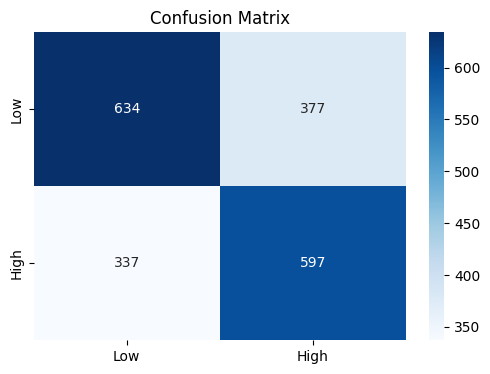

In [28]:
# Confusion Matrix Visualization
conf_mat = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix')
plt.show()

In [30]:
# SECTION 5: Collaborative Filtering (SVD)
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
svd_model = SVD()
svd_model.fit(trainset)
predictions = svd_model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8803


0.8803038085783687

In [32]:
# SECTION 6: Clustering Model (K-Means on Genres)
X_genres = movies_with_genres.drop(columns=['movieId', 'title'])
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_genres)
movies_with_clusters = movies_with_genres.copy()
movies_with_clusters['cluster'] = cluster_labels
sil_score = silhouette_score(X_genres, cluster_labels)
print(f"Silhouette Score (k=5): {sil_score}")

Silhouette Score (k=5): 0.20641269254605452


/var/folders/5j/21g__tmn49j37fc_6jm0546c0000gn/T/ipykernel_28246/900710596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=movies_with_clusters, palette='Set2')


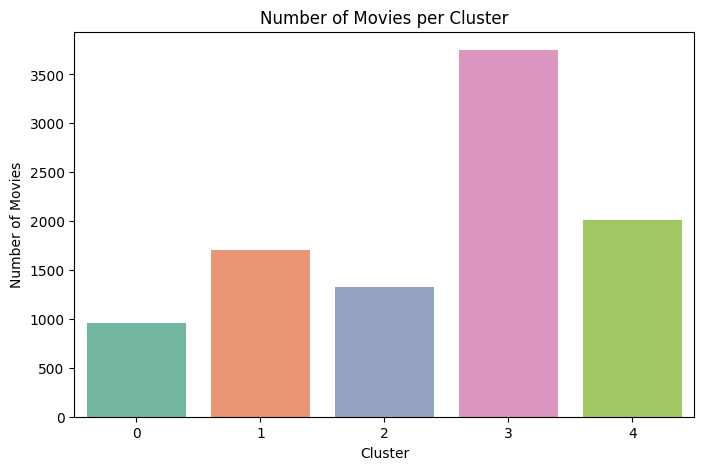

In [34]:
# Cluster distribution plot
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=movies_with_clusters, palette='Set2')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.show()

In [36]:
# SECTION 7: User Preference-Based Recommendations (Collaborative Filtering)
# Function to recommend top N movies for a given user based on SVD model
def recommend_movies_svd(user_id, movies_df, svd_model, ratings_df, top_n=10):
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    all_movies = movies_df['movieId'].tolist()
    unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]
    predictions = [svd_model.predict(user_id, movie_id) for movie_id in unrated_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_recommendations = predictions[:top_n]
    recommended_movies = pd.DataFrame([(pred.iid, pred.est) for pred in top_recommendations], columns=['movieId', 'estimated_rating'])
    recommended_movies = pd.merge(recommended_movies, movies_df[['movieId', 'title']], on='movieId')
    return recommended_movies[['title', 'estimated_rating']]

# Example usage for user 1
user_id = 4
user_recommendations = recommend_movies_svd(user_id, movies, svd_model, ratings, top_n=10)
print(f"Top 10 Recommendations for User {user_id}:")
print(user_recommendations)

Top 10 Recommendations for User 4:
                                               title  estimated_rating
0                                   Inception (2010)          4.640700
1                               Graduate, The (1967)          4.554441
2                   Shawshank Redemption, The (1994)          4.498063
3      Lord of the Rings: The Two Towers, The (2002)          4.486754
4  Spirited Away (Sen to Chihiro no kamikakushi) ...          4.456856
5                                    Whiplash (2014)          4.417804
6                             Midnight Cowboy (1969)          4.411018
7  Man Bites Dog (C'est arrivé près de chez vous)...          4.407705
8                              Godfather, The (1972)          4.402710
9                            Dark Knight, The (2008)          4.394420


In [38]:
# SECTION 8: Hybrid Recommendation System

# Function to recommend top N movies using Hybrid approach
def recommend_movies_hybrid(user_id, movies_df, svd_model, ratings_df, content_scores_df, popularity_scores_df, top_n=10):
    # Collaborative Filtering scores
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()
    all_movies = movies_df['movieId'].tolist()
    unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]
    collab_predictions = [svd_model.predict(user_id, movie_id) for movie_id in unrated_movies]
    collab_scores = pd.DataFrame([(pred.iid, pred.est) for pred in collab_predictions], columns=['movieId', 'collab_score'])

    # Merge with content-based scores
    hybrid_df = pd.merge(collab_scores, content_scores_df, on='movieId', how='left')
    # Merge with popularity scores
    hybrid_df = pd.merge(hybrid_df, popularity_scores_df, on='movieId', how='left')

    # Fill missing values
    hybrid_df['content_score'] = hybrid_df['content_score'].fillna(hybrid_df['content_score'].mean())
    hybrid_df['pop_score'] = hybrid_df['pop_score'].fillna(hybrid_df['pop_score'].mean())

    # Compute hybrid score
    hybrid_df['hybrid_score'] = (
        0.4 * hybrid_df['collab_score'] +
        0.3 * hybrid_df['content_score'] +
        0.3 * hybrid_df['pop_score']
    )

    # Recommend top N
    top_recommendations = hybrid_df.sort_values('hybrid_score', ascending=False).head(top_n)
    top_recommendations = pd.merge(top_recommendations, movies_df[['movieId', 'title']], on='movieId')
    return top_recommendations[['title', 'collab_score', 'content_score', 'pop_score', 'hybrid_score']]

# Prepare content-based scores
cosine_sim_matrix = cosine_similarity(movies_with_genres.drop(columns=['movieId', 'title']))
content_scores_df = pd.DataFrame({'movieId': movies_with_genres['movieId'], 'content_score': cosine_sim_matrix.mean(axis=0)})

# Prepare popularity scores
popularity_scores_df = qualified_movies[['movieId', 'weighted_rating']].rename(columns={'weighted_rating': 'pop_score'})

# Example Hybrid Recommendations for user 1
hybrid_recommendations = recommend_movies_hybrid(user_id, movies, svd_model, ratings, content_scores_df, popularity_scores_df, top_n=10)
print(f"Top 10 Hybrid Recommendations for User {user_id}:")
print(hybrid_recommendations)

Top 10 Hybrid Recommendations for User 4:
                                               title  collab_score  \
0                   Shawshank Redemption, The (1994)      4.498063   
1                                   Inception (2010)      4.640700   
2                               Graduate, The (1967)      4.554441   
3                              Godfather, The (1972)      4.402710   
4                            Dark Knight, The (2008)      4.394420   
5                                Forrest Gump (1994)      4.250139   
6  Spirited Away (Sen to Chihiro no kamikakushi) ...      4.456856   
7                                    Whiplash (2014)      4.417804   
8                          Lawrence of Arabia (1962)      4.287735   
9                               Boogie Nights (1997)      4.378344   

   content_score  pop_score  hybrid_score  
0       0.276689   4.396816      3.201277  
1       0.270951   4.018829      3.143214  
2       0.403241   3.981387      3.137165  
3       0.2

/var/folders/5j/21g__tmn49j37fc_6jm0546c0000gn/T/ipykernel_28246/3166752011.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='estimated_rating', y='title', data=user_recommendations, palette='Blues_d')


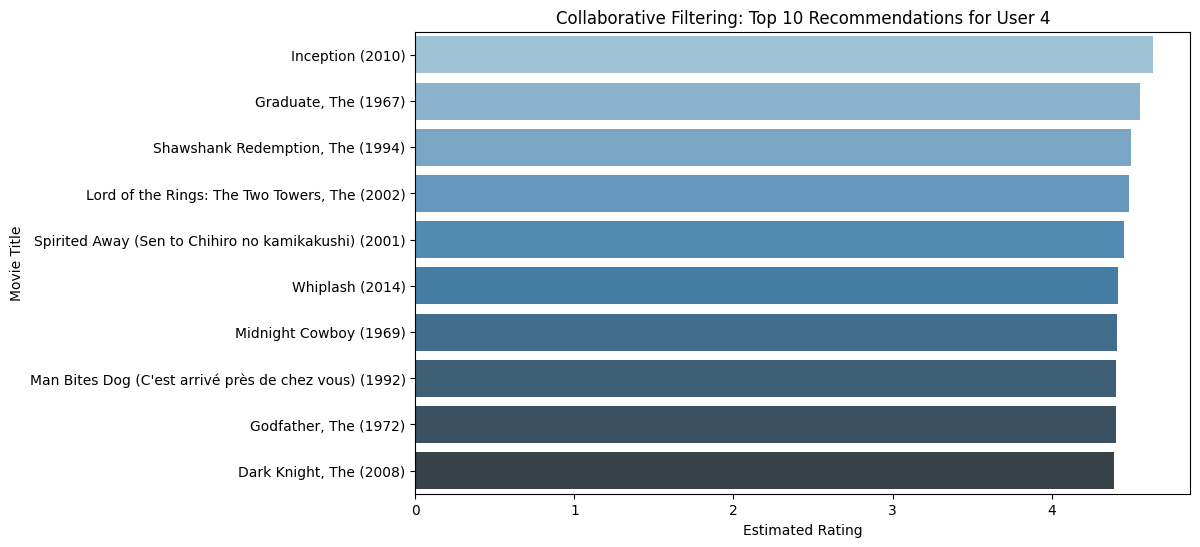

/var/folders/5j/21g__tmn49j37fc_6jm0546c0000gn/T/ipykernel_28246/3166752011.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hybrid_score', y='title', data=hybrid_recommendations, palette='Greens_d')


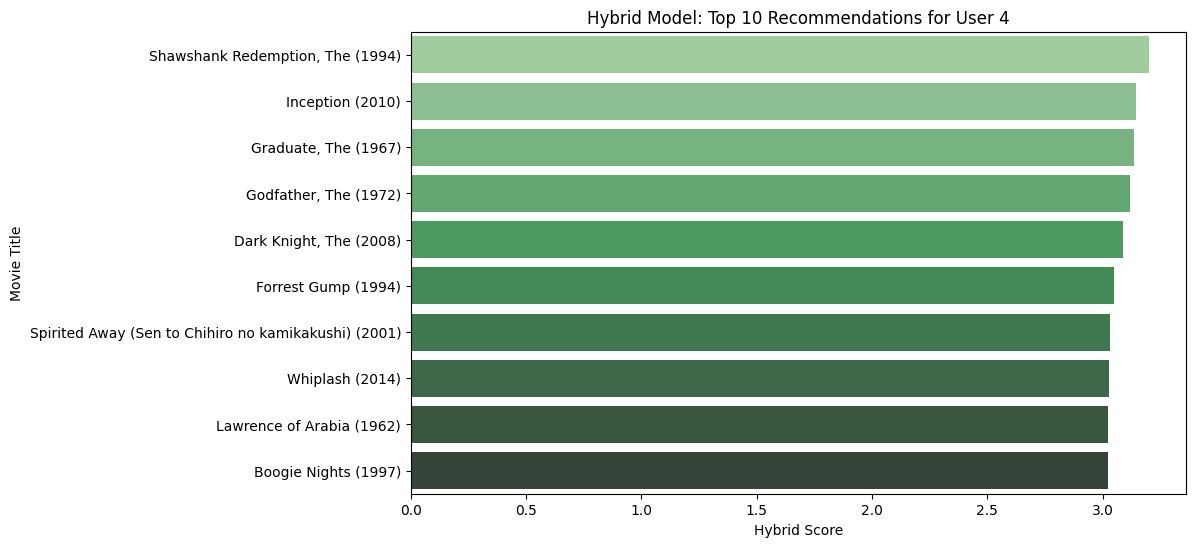

In [40]:
# SECTION 9: Visualizations for Recommendations

# Collaborative Filtering Recommendations Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='estimated_rating', y='title', data=user_recommendations, palette='Blues_d')
plt.title(f'Collaborative Filtering: Top 10 Recommendations for User {user_id}')
plt.xlabel('Estimated Rating')
plt.ylabel('Movie Title')
plt.show()

# Hybrid Recommendations Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='hybrid_score', y='title', data=hybrid_recommendations, palette='Greens_d')
plt.title(f'Hybrid Model: Top 10 Recommendations for User {user_id}')
plt.xlabel('Hybrid Score')
plt.ylabel('Movie Title')
plt.show()